Before we diverged into an investigation of representation/storage of Python variables $\mathtt{X}$ and $\mathtt{Y}$ (math variables $\bf{X}$ and $\bf{Y}$), we had the following equation: 

$$\min RSS(\beta)=(\bf{y}-\bf{X}\beta)^T(\bf{y}-\bf{X}\beta)$$

The question is, how do we solve it?  Well, if you recall your calculus, you should remember (or I'll remind you) that we can optimize (find the minima and maxima) of function by taking derivatives.  Let's back up to the summation version:

$$RSS(\beta)=\sum_{i=1}^N (y_i-(\beta_0+\sum_{j=1}^px_{i}\beta_j))^2$$

<!--more-->

When I'm wearing my computer scientist hat, I love to name things -- and that means creating a variable.  In this case, the weighted-sum of $x$ and $\beta$ is $f(x_i)$ (our predicted value for the input values making up $x_i$).  And, $y_i$ - $f(x_i) = e_i$ is the *error* in our prediction for $x_i$.  So, we can write:
$$RSS(\beta) = \sum_{i=1}^N (y_i - f(x_i))^2 = \sum_{i=1}^N e_{i}^2$$
We can also express the errors over the whole data set as $E=Y-X\beta$ and $RSS(\beta) = E^TE = dot(E,E)$

The derivative of a sum is the sum of the derivatives.  So, from the expanded form of $RSS$: 

$$RSS(\beta)=\sum_{i=1}^N (y_i-(\beta_0+\sum_{j=1}^px_{i}\beta_j))^2$$

We can compute each of the derivatives with respect to the $\beta$s:

$$\frac{\partial RSS(\beta)}{\partial \beta_j} = -2\sum_{i=1}^Ne_ix_{ij}$$

This is a rather nice looking expression.  It isn't too complicated ($e_i$ and $x_ij$ are scalars).  We'd like to do two things with it:  (1) turn the sum-of-products (i.e., another dot product) into an actual dot product and (2) we'd like to account for all of the $\beta_j$ for $j=0,\dots,p$.  Since we want to set the derivative w.r.t. all of the $beta_j$ equal to zero, we have a system of equations:
$$\begin{eqnarray}
\frac{\partial RSS(\beta)}{\partial \beta_0} &=& -2\sum_{i=1}^Ne_ix_{i,0} &= 0 \\
& &\vdots& \\
\frac{\partial RSS(\beta)}{\partial \beta_j} &=& -2\sum_{i=1}^Ne_ix_{i,j} &= 0 \\
& &\vdots& \\
\frac{\partial RSS(\beta)}{\partial \beta_p} &=& -2\sum_{i=1}^Ne_ix_{i,p} &= 0
\end{eqnarray}$$
Recall that $x_{i,0} = 1$ for all $i$.

Conceptually, we're taking a column of the data-matrix $X$ computing the dot-product with the error values.  That is, the error of example one times the value of first examples's feature (and then adding those up over all examples).  We need the "row-column" rule of matrix multiplication to pull together a data-matrix column and the errors.  A little thought leads to:
$$\frac{\partial RSS(\beta)}{\partial \beta} = -2 X^TE$$
The rules for matrix multiplication take row of $X^T$ (a column of $X$) times the column-vector $E$.  Just what we needed to concisely represent the dot-products and the system of equations.


We can now do some relatively straight forward manipulations to get an explicit, closed-form, solution for $\beta$:
$$\begin{eqnarray}
\frac{\partial RSS(\beta)}{\partial \beta} = -2 X^TE = -2 X^T(Y-X\beta) &=& 0 \\
X^TX\beta &=& X^TY \\
\beta&=&(X^TX)^{-1}X^TY 
\end{eqnarray}$$

One note, the product of $X$-related terms on the LHS (left hand side), $(X^TX)^{-1}X^T$, has a special name: the pseudo-inverse, or Moore-Penrose inverse, of $X$.  The next to last equation also has a special name:  the normal equation(s) (depending on whether you are talking in matrix terms or scalar terms).

### On to Some Code

In [1]:
import numpy as np

import numpy.linalg as nla
import scipy.linalg as sla

import matplotlib.pyplot as plt
%matplotlib inline

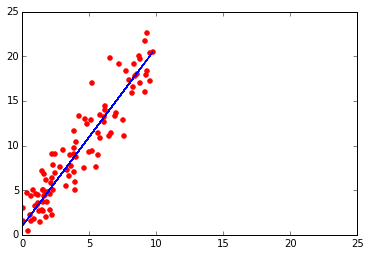

In [2]:
n_obs = 100
n_ftr = 1  # misnomer, we really have a constant term also
def f(x):  
    return 1+np.dot(x,2**np.arange(1,n_ftr+1))

X = np.random.uniform(0,10,(n_obs,n_ftr))
noise = np.random.normal(0.0, 2.0, n_obs)

Y = f(X) + noise

plt.scatter(X,Y, color='r') # Y's are exact + noise
plt.plot(X,f(X), 'b')       # f(X) is exact

plt.axis([0,25,0,25]);

Now, we can ask what happens if we come up with some $\beta$s?  How accurately does the model (that we created out of thin air) reflect the true underlying model `f(X)`?  Turns out, neither of them look very good and that isn't surprising -- we merely guessed at some values.  We can also quantify the amount of error by looking at the $RSS(model)$.

RSS (model a): 2918.56967295
RSS (model b): 12832.8298798


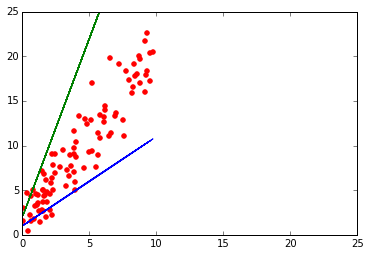

In [3]:
beta_hat_a = np.ones(n_ftr+1)               # \betas = 1,1,1,1
beta_hat_b = (np.arange(n_ftr+1) + 1.0) * 2 # \betas = 2,4,6,8, force float typing

plt.scatter(X,Y, color='r')

pred_a = beta_hat_a[0] + np.dot(X,beta_hat_a[1:])
pred_b = beta_hat_b[0] + np.dot(X,beta_hat_b[1:])

plt.plot(X, pred_a, 'b')
plt.plot(X, pred_b, 'g')

plt.axis([0,25,0,25]);

errors_a = Y - pred_a
errors_b = Y - pred_b
print "RSS (model a):", np.dot(errors_a, errors_a)
print "RSS (model b):", np.dot(errors_b, errors_b)

In spite of my comments about the transition from the data $X$ to the design matrix $D$ (namely the reallocation of space and copying time - both as $\mathcal{O}(X)$), I'm going to punt here.  The main reason is the mathematical (and here, computation) simplicity of working directly with the design matrix.  To account for the constant term, we manually append a column of ones and pass the design matrix to the solving routines.

If we wanted to account for the constant term as part of the overall model and use these solvers, we would have to somehow make use of the solvers to achieve a partial solution and perform other operations to account for the constant term (likely looking at the residuals and apportioning part of the residual to the constant term -- I haven't done the math).  Then, we'd have to take those two partial solutions and compute the final $\beta$s.  Ugh.  I'm going to leave that for furture work.  But if you are building a custom regression system, you'll have to make some trade-offs.  It all depends on how much (programmer) time and (computer) memory you have available.

Also, we'll use four different methods of computing the $\beta$s.  I won't comment on them now, but we'll dig into the differences between them in the next episode.

In [4]:
D = np.hstack((np.ones((n_obs,1)), X))
mle_betas_1 = nla.solve(D.T.dot(D), D.T.dot(Y))
mle_betas_2 = sla.solve(D.T.dot(D), D.T.dot(Y), sym_pos=True)
mle_betas_3 = sla.lstsq(D,Y)[0]
mle_betas_4 = nla.lstsq(D,Y)[0]

# pairwise compare the inferrred betas
print "all close to each other?", all([np.allclose(mle_betas_1, mle_betas_2),
                                       np.allclose(mle_betas_2, mle_betas_3),
                                       np.allclose(mle_betas_3, mle_betas_4)])
print mle_betas_3

all close to each other? True
[ 1.2245769   1.93952792]


Finally, we can look at how well our inferrred $\beta$s capture the original, true, underlying model.

RSS (mle model): 453.184077193


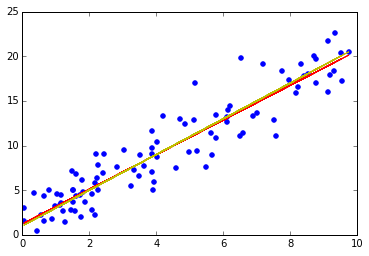

In [5]:
plt.scatter(X,Y, color='b')

pred_mle = mle_betas_3[0] + np.dot(X, mle_betas_3[1:])

plt.plot(X, pred_mle, 'r')
plt.plot(X, f(X), 'y')
plt.axis([0,10,0,25]);

errors_mle = Y - pred_mle
print "RSS (mle model):", np.dot(errors_mle, errors_mle)